In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('../../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import numpy as np
import tensorflow as tf

import ND_north_star.src.noise_generators.perlin_noise_generator as PNG # type: ignore
import ND_north_star.src.edge_detection.gradient_detection as ED_sim # type: ignore
from ND_north_star.src.utils.sampling_function import random_sampler # type: ignore
from ND_north_star.src.data_fillers.kNN_filler import kNN_data_filler # type: ignore

In [3]:
tf.config.list_physical_devices('GPU')

[]

Disable GPU

In [4]:
tf.config.set_visible_devices([], 'GPU')

## Generate dataset

In [5]:
resolution = 30
octaves = 4
dataset_size = 1024
drop_percs = [x/100 for x in range(0, 100, 5)]

In [6]:
data_path = "data/"
if not os.path.exists(data_path):
    os.makedirs(data_path)
data_path = "data/"

In [7]:
# dataset = np.array([PNG.ND_perlin_matrix([resolution, resolution], octaves=octaves, noise_cutoff_list=[0.5, 0, 1]) for _ in range(dataset_size)])
# np.save(data_path+'{resolution}x{resolution}_{octaves}_{dataset_size}_dataset.npy'.format(resolution=resolution, octaves=octaves, dataset_size=dataset_size), dataset)

In [8]:
dataset = np.load(data_path+'{resolution}x{resolution}_{octaves}_{dataset_size}_dataset.npy'.format(resolution=resolution, octaves=octaves, dataset_size=dataset_size))

In [9]:
from sklearn.preprocessing import MinMaxScaler

def perlin_M_to_dict(dimension_resolution, octaves, perlin_matrix):
    
    # Convert list to numpy array if needed
    array = np.array(perlin_matrix)
    shape = array.shape
 
    # Generate all possible coordinates in the N-dimensional array
    coordinates = np.indices(shape).reshape(len(shape), -1).T
    data = []      
    # Iterate over the coordinates and get the corresponding values
    for coord in coordinates:
        value = array[tuple(coord)]
        data.append(list(coord) + [value])
    
    # Separate the features and the value column
    features = [d[:-1] for d in data]
    values = [d[-1] for d in data]
    
    # Normalize the feature columns
    scaler = MinMaxScaler()
    normalized_features = scaler.fit_transform(features)
    
    # Create the output dictionary
    perlin_dict = {
        'features': normalized_features.tolist(),
        'values': values,
        'resolution': dimension_resolution,
        'coordinates': [f'x{i}' for i in range(len(shape))],
        'octaves': octaves,
        'dimension': len(dimension_resolution),
    }
    
    return perlin_dict

In [10]:
dict_dataset = [perlin_M_to_dict([resolution, resolution], octaves, m) for m in dataset]

In [11]:
X = [None for _ in range(len(drop_percs))]
for i, drop_perc in enumerate(drop_percs):
    X[i] = np.array([random_sampler(d, int(resolution*resolution*(1-drop_perc))) for d in dict_dataset])

In [12]:
y = dataset.copy()

Use gradient edge detection to generate edges.

In [13]:
edge = np.array([ED_sim.gradient_edge_detection(dataset[i]) for i in range(dataset_size)]).astype(int)

## Train test split

In [14]:
from sklearn.model_selection import train_test_split

In [15]:
indices_train = [0 for _ in range(len(drop_percs))]
indices_test = [0 for _ in range(len(drop_percs))]

In [16]:
seed = 3834
for i in range(len(drop_percs)):
    indices_train[i], indices_test[i] = train_test_split(range(dataset_size), random_state=seed+i)

## kNN

In [17]:
def weighted_cross_entropy(y_true, y_pred):
    y_pred = tf.cast(y_pred, tf.float32)
    y_pred = tf.where(tf.equal(y_pred, 0), tf.ones_like(y_pred)*1e-7, y_pred)
    y_pred = tf.where(tf.equal(y_pred, 1), tf.ones_like(y_pred)*(1-1e-7), y_pred)

    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    a = tf.reduce_sum(y_true_f)/y_true_f.shape[0]
    b = 1 - a
    return -a*tf.experimental.numpy.inner(1-y_true_f, tf.math.log(1-y_pred_f))-b*tf.experimental.numpy.inner(y_true_f, tf.math.log(y_pred_f))

In [18]:
from sklearn.metrics import mean_squared_error

filled_X_matrices = [None for _ in range(len(drop_percs))]
pred = [None for _ in range(len(drop_percs))]
wces = np.zeros(len(drop_percs))
mses = np.zeros(len(drop_percs))

for i, drop_perc in enumerate(drop_percs):
    X_train = X[i][indices_train[i]]
    y_train = y[indices_train[i]]
    X_test = X[i][indices_test[i]]
    y_test = y[indices_test[i]]

    filled_X = [kNN_data_filler(d, rounding_threshold=0.9) for d in X_test]
    filled_X_matrices[i] = np.zeros((dataset_size, resolution, resolution))
    for j in range(len(X_test)):
        for k in range(resolution*resolution):
            coords = np.round(filled_X[j]['features']*(resolution-1))[k].astype(int)
            filled_X_matrices[i][j][coords[0]][coords[1]] = filled_X[j]['values'][k]
    
    pred[i] = [ED_sim.gradient_edge_detection(m) for m in filled_X_matrices[i]]
    
    wces[i] = np.mean([weighted_cross_entropy(edge[indices_test[i]][j], pred[i][j]) for j in range(len(y_test))])
    mses[i] = np.mean([mean_squared_error(edge[indices_test[i]][j], pred[i][j]) for j in range(len(y_test))])

In [19]:
np.save(data_path+'knn_filling_gd_{resolution}x{resolution}_{octaves}_{dataset_size}_pred.npy'.format(resolution=resolution, octaves=octaves, dataset_size=dataset_size), pred)

np.save(data_path+'knn_filling_gd_{resolution}x{resolution}_{octaves}_{dataset_size}_mses.npy'.format(resolution=resolution, octaves=octaves, dataset_size=dataset_size), mses)

np.save(data_path+'knn_filling_gd_{resolution}x{resolution}_{octaves}_{dataset_size}_wces.npy'.format(resolution=resolution, octaves=octaves, dataset_size=dataset_size), wces)

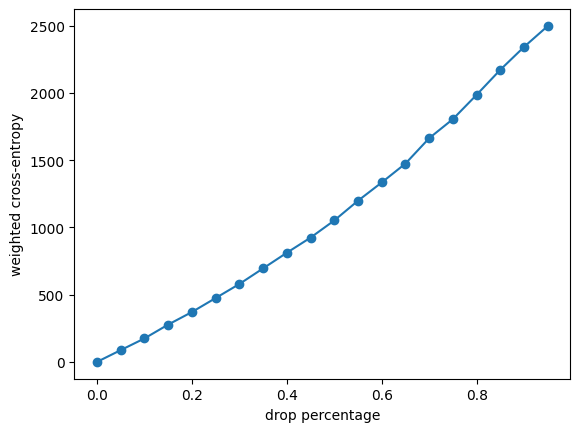

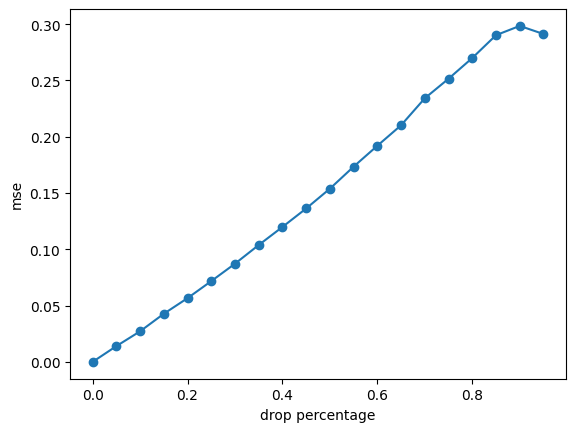

In [20]:
import matplotlib.pyplot as plt

plt.plot(drop_percs, wces, marker='o')
plt.xlabel("drop percentage")
plt.ylabel("weighted cross-entropy")
plt.show()

plt.plot(drop_percs, mses, marker='o')
plt.xlabel("drop percentage")
plt.ylabel("mse")
plt.show()

## Some visualization

In [21]:
d = 0.5 # drop ratio
n = 6
cmap = 'gray_r'

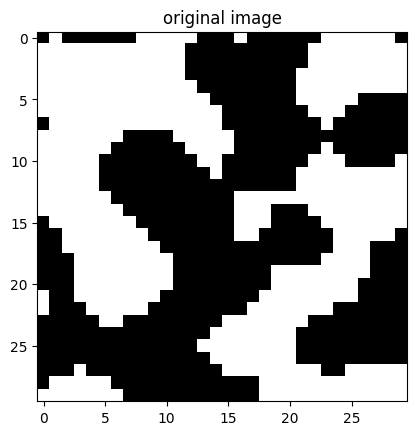

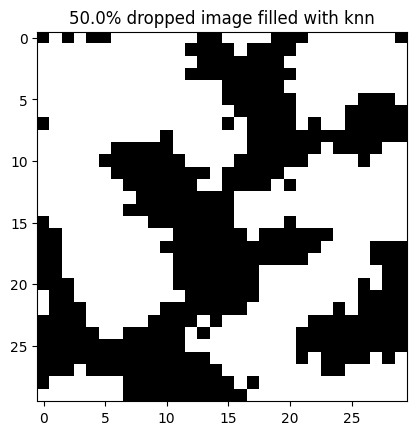

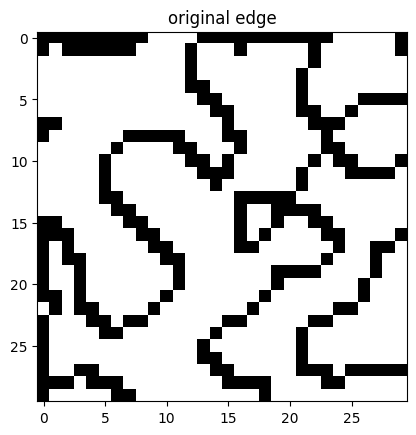

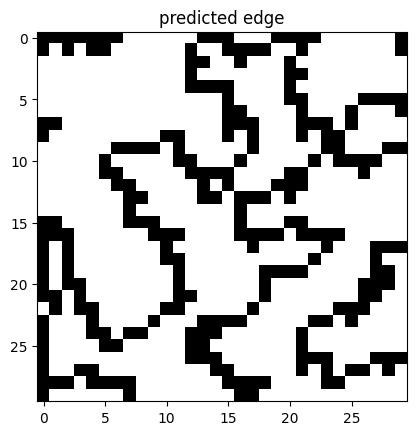

In [22]:
m = drop_percs.index(d)
k = indices_test[drop_percs.index(d)][n]

plt.imshow(dataset[k], cmap=cmap)
plt.title("original image")
plt.show()
plt.imshow(filled_X_matrices[m][n], cmap=cmap)
plt.title("{drop_perc}% dropped image filled with knn".format(drop_perc = drop_percs[m]*100))
plt.show()
plt.imshow(edge[indices_test[m]][n], cmap=cmap)
plt.title("original edge")
plt.show()
plt.imshow(pred[m][n], cmap=cmap)
plt.title("predicted edge")
plt.show()